# **Face Recognition Project**

### Загрузка и предобработка данных

In [1]:
import requests
from urllib.parse import urlencode
import numpy as np

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/S8f03spLIA1wrw'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('downloaded_file.zip', 'wb') as f:
    f.write(download_response.content)

Разархивируем downloaded_file.zip

In [3]:
import zipfile

with zipfile.ZipFile('downloaded_file.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

Удалим ненужные файлы

In [4]:
import os

filename = 'downloaded_file.zip'

# Если файл существует, удаляем
if os.path.exists(filename):
    os.remove(filename)
    print(filename + " deleted")

downloaded_file.zip deleted


In [5]:
import shutil

filename = '/content/extracted_files/__MACOSX'

# Если файл существует, удаляем
if os.path.exists(filename):
    shutil.rmtree(filename)
    print(filename + " deleted")

/content/extracted_files/__MACOSX deleted


    Внутри:
            - celebA_imgs — папка с выровненными картинками;
            - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
            - celebA_train_split.txt — файл со сплитом на train/val/test.

In [6]:
import pandas as pd

In [7]:
from PIL import Image
import torch
from torch.utils.data import Dataset

from matplotlib import pyplot as plt

In [8]:
data_modes = ["train", "val", "test"]

In [ ]:
df_anno = pd.read_csv("/content/extracted_files/celebA_train_500/celebA_anno.txt", sep='\s+', header=None)
df_split = pd.read_csv("/content/extracted_files/celebA_train_500/celebA_train_split.txt", sep='\s+', header=None)

In [ ]:
ids = np.array(['000001.jpg', '000404.jpg', '101501.jpg'])

In [9]:
from torchvision import transforms, models

Создадим custom Dataset для подготовки данных

In [10]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, anno_file, split_file, mode):
        self.mode = mode
        if self.mode not in data_modes:
            print(f"{self.mode} is not correct; correct modes: {data_modes}")
            raise NameError
        self.img_dir = img_dir
        self.anno = pd.read_csv(anno_file, sep='\s+', header=None)
        self.train_split = pd.read_csv(split_file, sep='\s+', header=None)

        if mode == "train":
            self.img_ids = self.train_split[self.train_split[1] == 0][0].values
            # self.indices = {img_id: idx for idx, img_id in enumerate(self.img_ids)}
            self.labels = {img_id: label for img_id, label in self.anno[self.anno[0].isin(self.img_ids)].values}
        elif mode == "val":
            self.img_ids = self.train_split[self.train_split[1] == 1][0].values
            # self.indices = {img_id: idx for idx, img_id in enumerate(self.img_ids)}
            self.labels = {img_id: label for img_id, label in self.anno[self.anno[0].isin(self.img_ids)].values}
        else:
            self.img_ids = self.train_split[self.train_split[1] == 2][0].values
            # self.indices = {img_id: idx for idx, img_id in enumerate(self.img_ids)}
            self.labels = {img_id: label for img_id, label in self.anno[self.anno[0].isin(self.img_ids)].values}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, img_id)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std of Imagenet
        ])

        image = np.array(Image.open(img_path))
        image = Image.fromarray(image[77:-41, 45:-50])
        image = image.resize((224, 224))
        image = np.array(image)
        image = np.array(image / 255, dtype='float32')
        image = transform(image)

        label = self.labels[img_id]
        return image, label

In [11]:
img_dir="/content/extracted_files/celebA_train_500/celebA_imgs"
anno_file="/content/extracted_files/celebA_train_500/celebA_anno.txt"
split_file="/content/extracted_files/celebA_train_500/celebA_train_split.txt"

tr_dataset = CelebADataset(
    img_dir=img_dir,
    anno_file=anno_file,
    split_file=split_file,
    mode="train"
)
val_dataset = CelebADataset(
    img_dir=img_dir,
    anno_file=anno_file,
    split_file=split_file,
    mode="val"
)
test_dataset = CelebADataset(
    img_dir=img_dir,
    anno_file=anno_file,
    split_file=split_file,
    mode="test"
)

Напишем функцию для вывода картинки

In [12]:
def imshow(inp, plt_ax=plt):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.axis(False)
    plt_ax.imshow(inp)

И теперь посмотрим на лица в нашем датасете

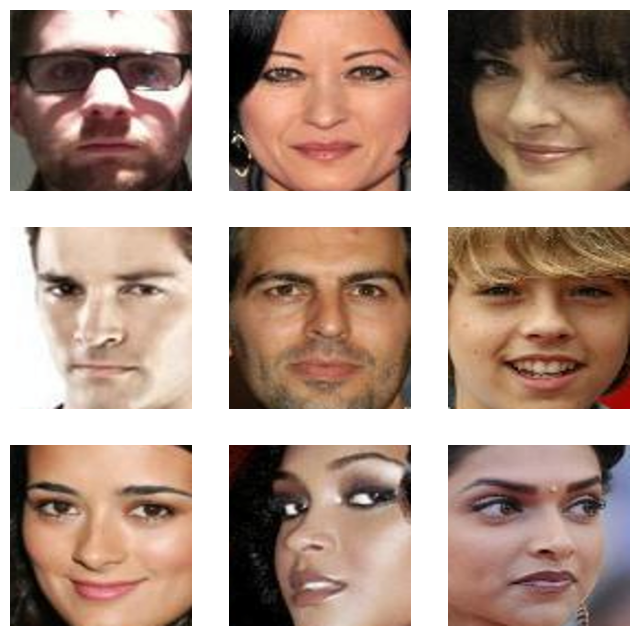

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for ax in axes.flatten():
    rand_person = int(np.random.uniform(0, val_dataset.__len__()))
    im_val, label = val_dataset[rand_person]
    imshow(im_val.data.cpu(), plt_ax=ax)

### Обучение модели

In [14]:
from torch.utils.data import DataLoader

In [15]:
import torch.nn as nn

In [17]:
tr_dataloader = DataLoader(tr_dataset, batch_size=32, num_workers=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Напишем функцию обучения

In [21]:
def train(train_data, val_data, model, optimizer, criterion, epochs):
    history = []
    optimizer = optimizer
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss_per_epoch = []
        running_corrects = 0
        processed_data = 0
        for X_batch, y_batch in train_data:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)

            train_loss_per_epoch.append(loss.item())
            running_corrects += torch.sum(preds == y_batch)
            processed_data += y_batch.size(0)
        train_loss = np.mean(train_loss_per_epoch)
        train_acc = running_corrects / processed_data

        model.eval()
        val_loss_per_epoch = []
        running_corrects = 0
        processed_data = 0
        for X_batch, y_batch in val_data:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            with torch.no_grad():
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                preds = torch.argmax(outputs, 1)
            val_loss_per_epoch.append(loss.item())
            running_corrects += torch.sum(preds == y_batch)
            processed_data += y_batch.size(0)

        val_loss = np.mean(val_loss_per_epoch)
        val_acc = running_corrects / processed_data

        history.append((train_loss, train_acc, val_loss, val_acc))
        print(f"Epoch: {epoch} train_loss: {train_loss} val_loss: {val_loss} \
        train_acc: {train_acc} val_acc: {val_acc}")

    return history

In [22]:
model = models.resnet50(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 62.1MB/s]


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [24]:
history = train(tr_dataloader, val_dataloader, model, optimizer, loss_fn, 10)

Epoch: 0 train_loss: 6.35416404495525 val_loss: 5.695356102313026         train_acc: 0.011704119853675365 val_acc: 0.04845580458641052
Epoch: 1 train_loss: 4.468856054298887 val_loss: 4.2044648558406506         train_acc: 0.19475655257701874 val_acc: 0.20926517248153687
Epoch: 2 train_loss: 2.1369076016243924 val_loss: 3.6104538804393704         train_acc: 0.6012406349182129 val_acc: 0.29605963826179504
Epoch: 3 train_loss: 0.6529458297995593 val_loss: 3.3739889799538307         train_acc: 0.896769642829895 val_acc: 0.32854098081588745
Epoch: 4 train_loss: 0.13273496547720853 val_loss: 3.251965773307671         train_acc: 0.9908707737922668 val_acc: 0.3466453552246094
Epoch: 5 train_loss: 0.02965589499707972 val_loss: 3.19659616987584         train_acc: 0.9991807341575623 val_acc: 0.35995739698410034
Epoch: 6 train_loss: 0.01389326017231363 val_loss: 3.2046485714993236         train_acc: 1.0 val_acc: 0.3647497296333313
Epoch: 7 train_loss: 0.009360138238808803 val_loss: 3.2012183585409

In [25]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

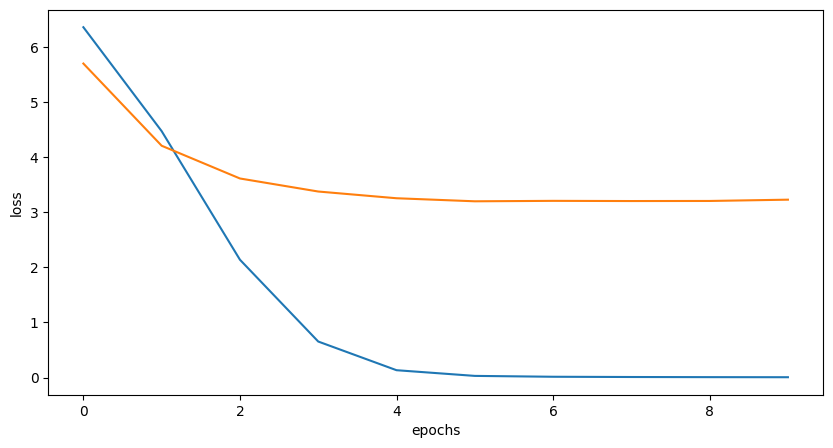

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [38]:
train_loss

(6.35416404495525,
 4.468856054298887,
 2.1369076016243924,
 0.6529458297995593,
 0.13273496547720853,
 0.02965589499707972,
 0.01389326017231363,
 0.009360138238808803,
 0.006873790795604388,
 0.005523332655394959)

In [42]:
train_acc

(tensor(0.0117, device='cuda:0'),
 tensor(0.1948, device='cuda:0'),
 tensor(0.6012, device='cuda:0'),
 tensor(0.8968, device='cuda:0'),
 tensor(0.9909, device='cuda:0'),
 tensor(0.9992, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(1., device='cuda:0'))

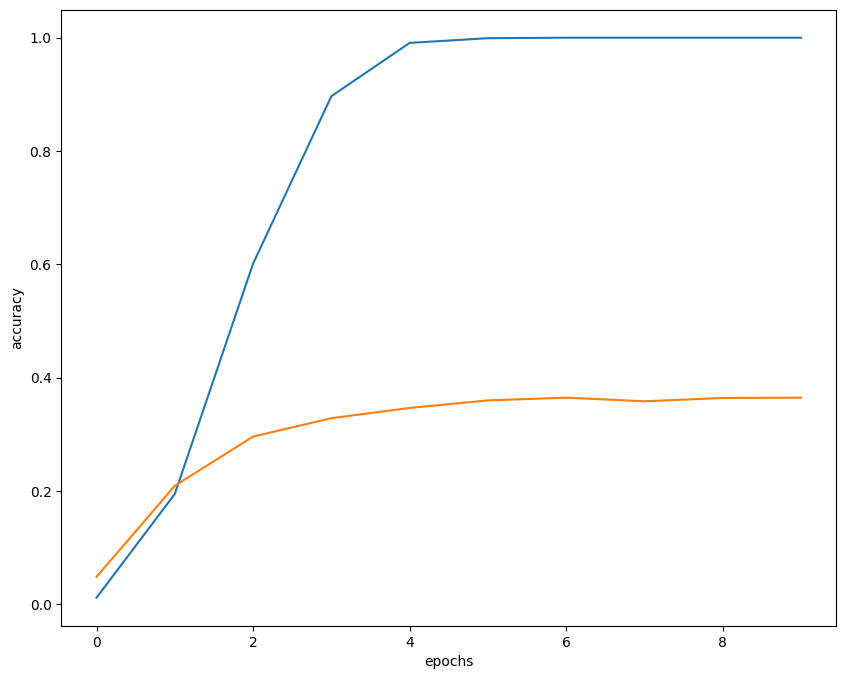

In [47]:
train_acc = [acc.cpu() for acc in train_acc]
val_acc = [acc.cpu() for acc in val_acc]

plt.figure(figsize=(10,8))
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()